<a href="https://colab.research.google.com/github/swilsonmfc/linear/blob/main/Insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Insurance
![](https://www.investopedia.com/thmb/NP3V49p3b0X1OWnJ72evtRNFAxE=/1200x800/filters:fill(auto,1)/insurance-c9070880c4e84d3b821760849fbdb21b.jpg)

# Install

In [1]:
!pip install data-describe
!pip install yellowbrick

     |████████████████████████████████| 71kB 4.3MB/s 
     |████████████████████████████████| 22.2MB 1.5MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
# Yellowbrick can't work with sklearn==0.24
!pip install scikit-learn==0.23

     |████████████████████████████████| 7.3MB 8.1MB/s 
  Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


# Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import data_describe as dd

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.stats.api as sms

from yellowbrick.regressor import prediction_error
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import AlphaSelection
from yellowbrick.regressor import ManualAlphaSelection

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



# Data

In [4]:
raw_df = pd.read_csv('https://github.com/swilsonmfc/linear/raw/main/insurance-ex.csv')

In [5]:
raw_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0.0,yes,southwest,16884.92400
1,18,male,33.770,1.0,no,southeast,1725.55230
2,28,male,33.000,3.0,no,southeast,4449.46200
3,33,male,22.705,0.0,no,northwest,21984.47061
4,32,male,NaN,0.0,no,northwest,3866.85520


# EDA

## First Glance
* Null values
* Age could be binned
* Contains numeric and categorical features
* Smoker (3 Categories -- yes, no, n)

In [6]:
dd.data_summary(raw_df)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning:

invalid value encountered in reduce



,Info
Rows,1338
Columns,7
Size in Memory,73.3 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
age,int64,0,0,18,39,64,39.21,14.045,47,69
sex,object,11,0,,,,,,2,670
bmi,float64,14,0,16.82,30.38,53.13,,,547,14
children,float64,7,0,0,1,5,,,6,573
smoker,object,6,0,,,,,,3,1058
region,object,9,0,,,,,,4,363
charges,float64,0,0,1121.87,9382.033,63770.43,13270.42,12105.48,1337,2


None

data-describe Summary Widget

## Observable Patterns
* Are there blocks of data that form patterns
* Looks reasonably devoid of a pattern

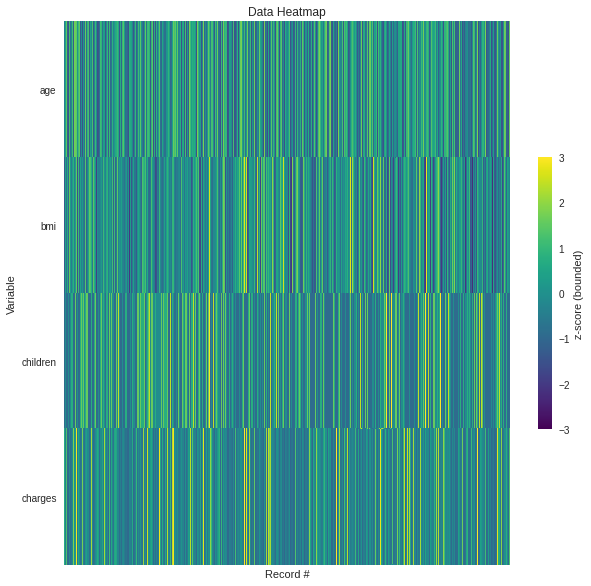

Heatmap Widget showing standardized values.

In [7]:
dd.data_heatmap(raw_df)

# Univariate Exploration

## Age
* More 20 values, but generally looking uniform
* Could be a candidate for binning

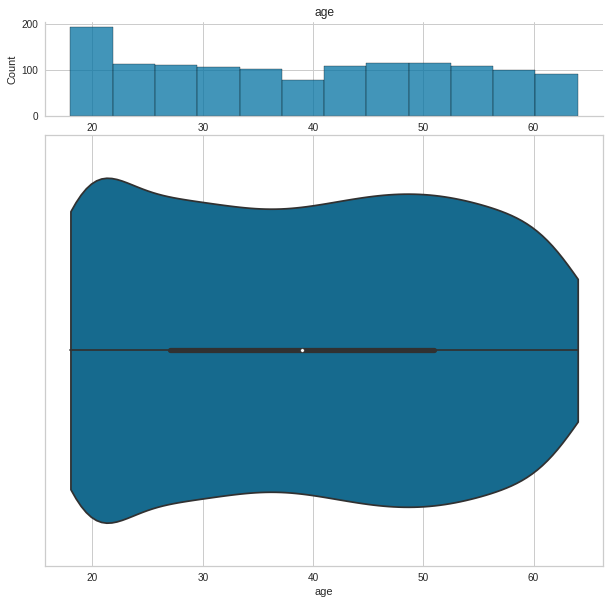

In [8]:
display(dd.distribution(raw_df[['age']]).plot_distribution('age'))

## Smoker
* Skewed to non-smoker

/usr/local/lib/python3.6/dist-packages/data_describe/metrics/univariate.py:23: RuntimeWarning:

invalid value encountered in true_divide



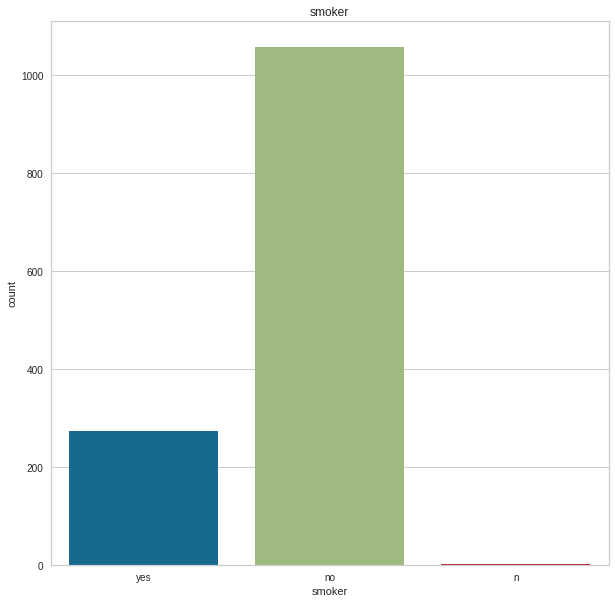

In [9]:
display(dd.distribution(raw_df[['smoker']]).plot_distribution('smoker'))

## Children
* No children is the mode
* Of people having children 1 or 2 seems typical

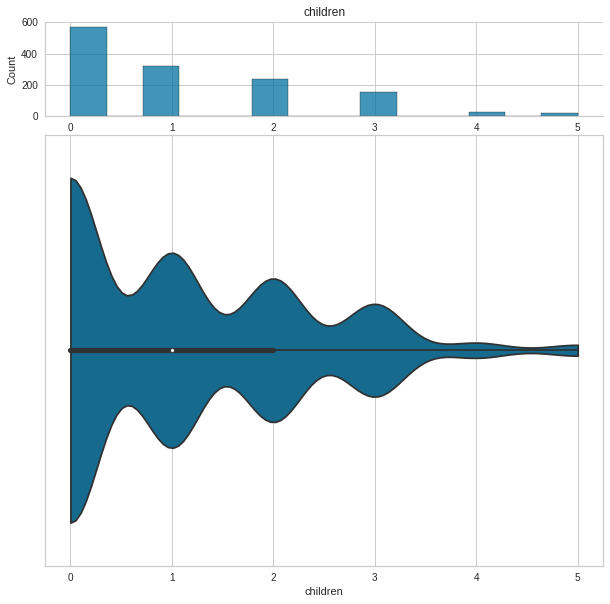

In [10]:
display(dd.distribution(raw_df[['children']]).plot_distribution('children'))

## Region
* Fairly evenly distributed

/usr/local/lib/python3.6/dist-packages/data_describe/metrics/univariate.py:23: RuntimeWarning:

invalid value encountered in true_divide



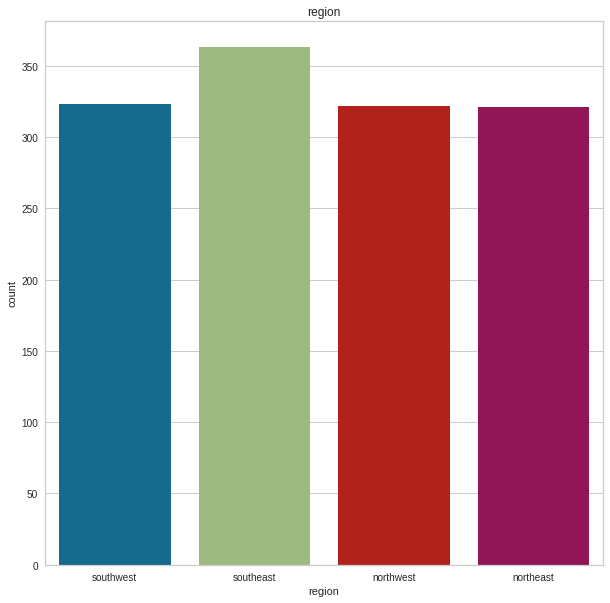

In [11]:
display(dd.distribution(raw_df[['region']]).plot_distribution('region'))

## BMI
* Fairly wide standard distribution centered around 30
* Slight right skew

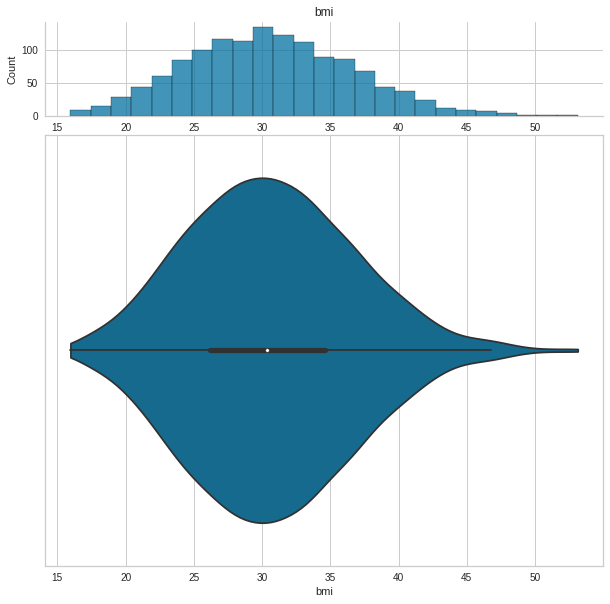

In [12]:
display(dd.distribution(raw_df[['bmi']]).plot_distribution('bmi'))

## Charges

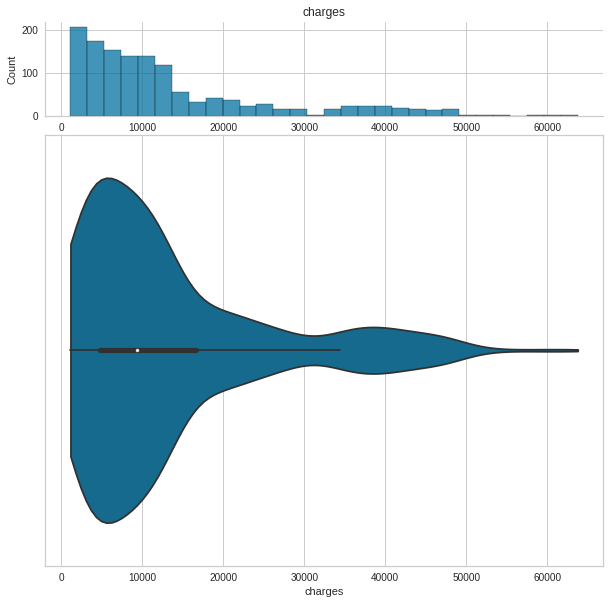

In [13]:
display(dd.distribution(raw_df[['charges']]).plot_distribution('charges'))

# Multivariate Exploration

## Correlation
* Low correlation of numeric values
* Multicolinearity might not be a big concern

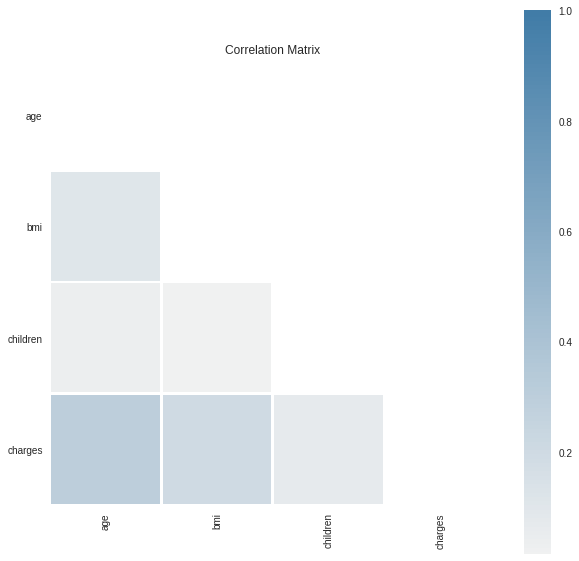

In [14]:
dd.correlation_matrix(raw_df)

## Panel / Scatter

data-describe Scatter Plot Widget

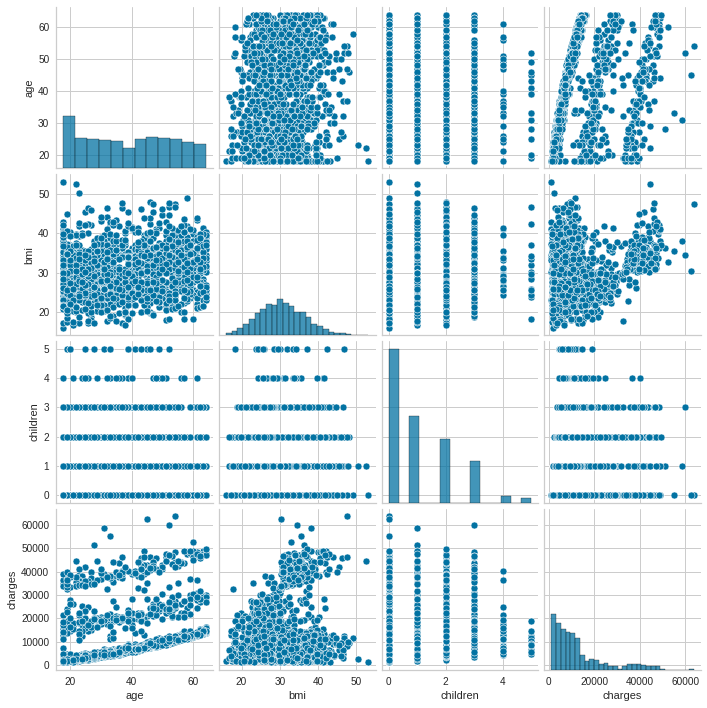

In [15]:
dd.scatter_plots(raw_df, plot_mode='matrix')

Cluster Widget using kmeans

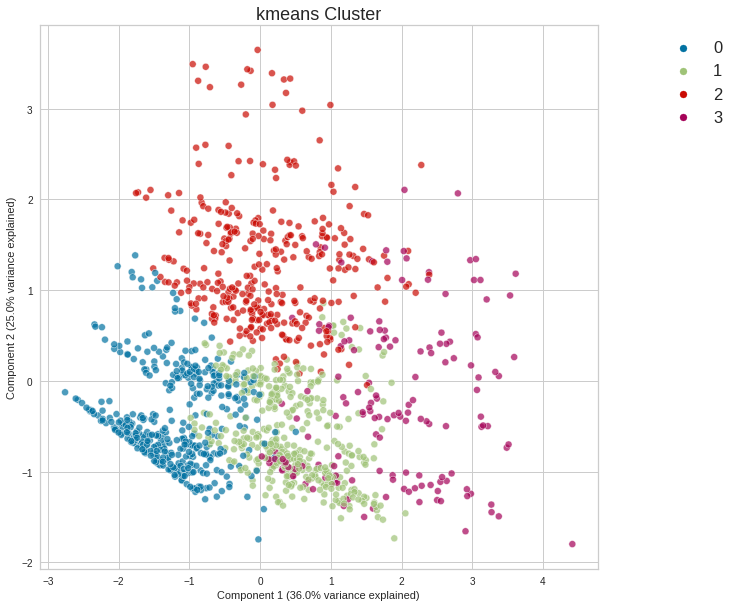

In [16]:
dd.cluster(raw_df.dropna())

## Importance
* Use a RandomForest to identify important features
* Permutation Importance Value = the decrease in score when we shuffle values of a single feature (Large score drops = important feature)

Text(0.5, 1.0, 'Feature Importance')

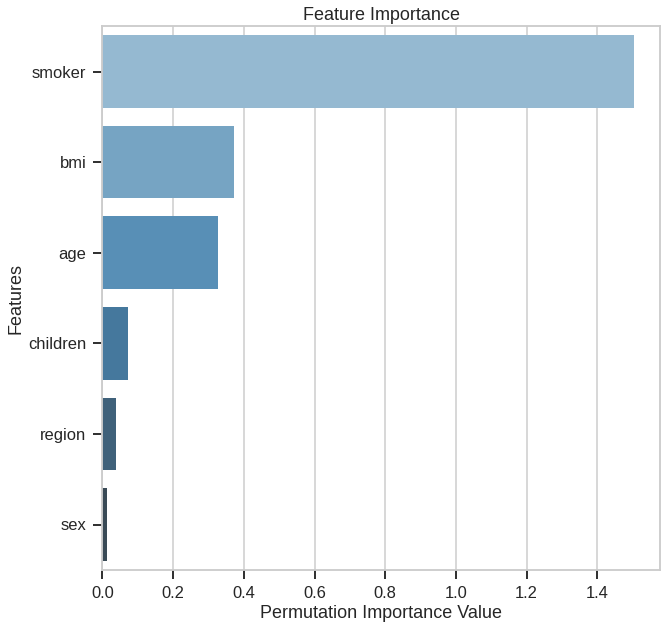

In [17]:
dd.importance(raw_df, 'charges', estimator=RandomForestRegressor(random_state=42))

# Missing Data
* Not many items (47 items with a missing value)
  * Delete / remove
  * Impute 
* Imputation Strategies
  * SimpleImputer vs IterativeImputer
  * missingpy
    * K-NN
    * MissForest https://arxiv.org/abs/1105.0828

In [18]:
df = raw_df.copy()
df['age_missing']      = np.where(pd.isnull(df.age), 1, 0)
df['children_missing'] = np.where(pd.isnull(df.children), 1, 0)

df['sex'] = np.where(df.sex == 'female', 0, df.sex)
df['sex'] = np.where(df.sex == 'male',   1, df.sex)
df['sex_missing'] = np.where(pd.isnull(df.sex), 1, 0)

df['smoker'] = np.where(df.smoker == 'yes', 1, df.smoker)
df['smoker'] = np.where(df.smoker == 'no',  0, df.smoker)
df['smoker'] = np.where(df.smoker == 'n',   0, df.smoker)
df['smoker_missing'] = np.where(pd.isnull(df.smoker), 1, 0)

df['region'] = np.where(pd.isnull(df.region), 'unknown', df.region)
df['region'] = df.region.astype('category')
region_encoder = LabelEncoder()
df['region'] = region_encoder.fit_transform(df.region)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   sex               1327 non-null   object 
 2   bmi               1324 non-null   float64
 3   children          1331 non-null   float64
 4   smoker            1332 non-null   object 
 5   region            1338 non-null   int64  
 6   charges           1338 non-null   float64
 7   age_missing       1338 non-null   int64  
 8   children_missing  1338 non-null   int64  
 9   sex_missing       1338 non-null   int64  
 10  smoker_missing    1338 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 115.1+ KB


In [19]:
imputer = IterativeImputer(max_iter=10, random_state=0)
imputed = imputer.fit_transform(df)
imputed_df = pd.DataFrame(imputed, columns=df.columns)

imputed_df['sex']      = np.where(imputed_df.sex > .5, 1, 0)
imputed_df['smoker']   = np.where(imputed_df.smoker > 0.5, 1, 0) 
imputed_df['children'] = imputed_df.children.round()

In [20]:
imputed_df

,age,sex,bmi,children,smoker,region,charges,age_missing,children_missing,sex_missing,smoker_missing
0,19.0,0,27.900000,0.0,1,3.0,16884.92400,0.0,0.0,0.0,0.0
1,18.0,1,33.770000,1.0,0,2.0,1725.55230,0.0,0.0,0.0,0.0
2,28.0,1,33.000000,3.0,0,2.0,4449.46200,0.0,0.0,0.0,0.0
3,33.0,1,22.705000,0.0,0,1.0,21984.47061,0.0,0.0,0.0,0.0
4,32.0,1,29.475913,0.0,0,1.0,3866.85520,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1333,50.0,1,30.970000,3.0,0,4.0,10600.54830,0.0,0.0,0.0,0.0
1334,18.0,0,31.920000,0.0,0,0.0,2205.98080,0.0,0.0,0.0,0.0
1335,18.0,0,36.850000,0.0,0,2.0,1629.83350,0.0,0.0,0.0,0.0
1336,21.0,0,25.800000,0.0,0,3.0,2007.94500,0.0,0.0,0.0,0.0


# Scaling

In [21]:
imputed_df['age'] = (imputed_df.age - np.mean(imputed_df.age)) / np.std(imputed_df.age)
imputed_df['bmi'] = (imputed_df.bmi - np.mean(imputed_df.bmi)) / np.std(imputed_df.bmi)

In [22]:
imputed_df

,age,sex,bmi,children,smoker,region,charges,age_missing,children_missing,sex_missing,smoker_missing
0,-1.438764,0,-0.451568,0.0,1,3.0,16884.92400,0.0,0.0,0.0,0.0
1,-1.509965,1,0.515937,1.0,0,2.0,1725.55230,0.0,0.0,0.0,0.0
2,-0.797954,1,0.389024,3.0,0,2.0,4449.46200,0.0,0.0,0.0,0.0
3,-0.441948,1,-1.307818,0.0,0,1.0,21984.47061,0.0,0.0,0.0,0.0
4,-0.513149,1,-0.191823,0.0,0,1.0,3866.85520,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1333,0.768473,1,0.054436,3.0,0,4.0,10600.54830,0.0,0.0,0.0,0.0
1334,-1.509965,0,0.211017,0.0,0,0.0,2205.98080,0.0,0.0,0.0,0.0
1335,-1.509965,0,1.023589,0.0,0,2.0,1629.83350,0.0,0.0,0.0,0.0
1336,-1.296362,0,-0.797694,0.0,0,3.0,2007.94500,0.0,0.0,0.0,0.0


# Data Types

In [23]:
imputed_df['sex']      = imputed_df.sex.astype('category')
imputed_df['smoker']   = imputed_df.smoker.astype('category')
imputed_df['region']   = imputed_df.region.astype(int).astype('category')

# Bivariate - Outcome

## Region - Charges

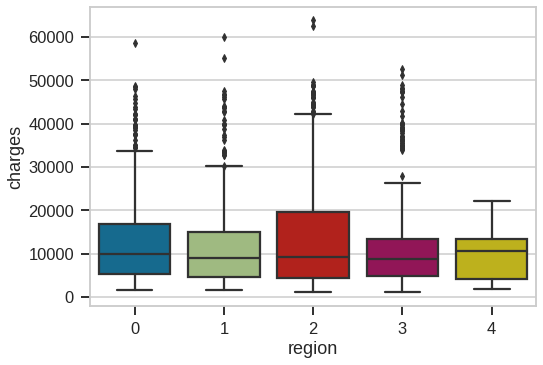

In [24]:
sns.boxplot(data=imputed_df, x='region', y='charges')

## Smoker - Charges

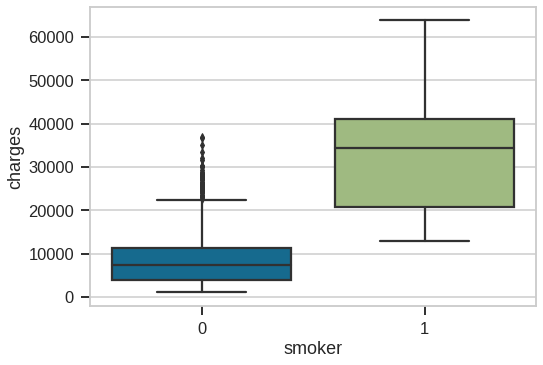

In [25]:
sns.boxplot(data=imputed_df, x='smoker', y='charges')

## Sex - Charges

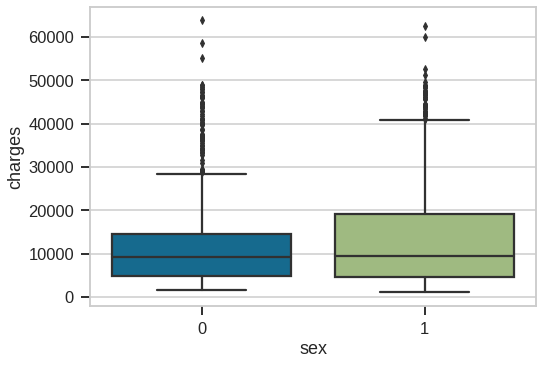

In [26]:
sns.boxplot(data=imputed_df, x='sex', y='charges')

## BMI - Charges

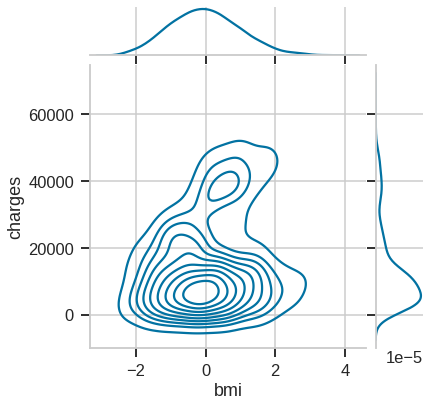

In [27]:
sns.jointplot(data=imputed_df, x='bmi', y='charges', kind='kde')

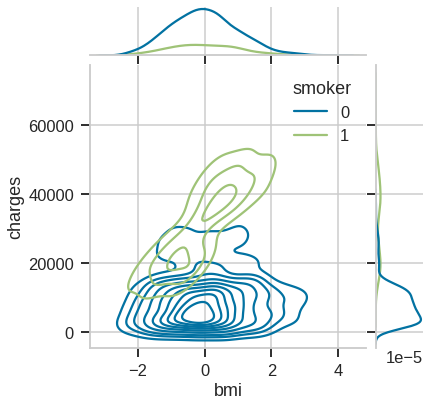

In [28]:
sns.jointplot(data=imputed_df, x='bmi', y='charges', hue='smoker', kind='kde')

## Age - Charges
* Three Bands

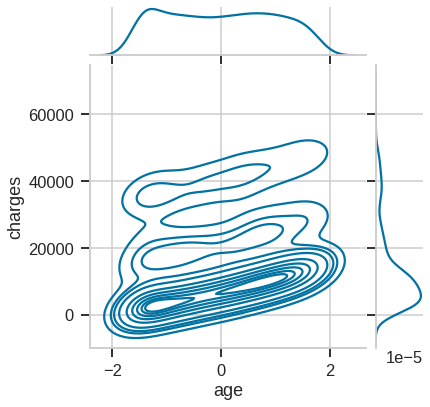

In [29]:
sns.jointplot(data=imputed_df, x='age', y='charges', kind='kde')

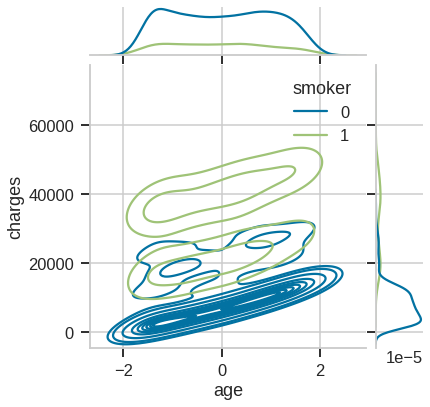

In [30]:
sns.jointplot(data=imputed_df, x='age', y='charges', hue='smoker', kind='kde')

# Train - Test

In [31]:
y = imputed_df.charges
X = imputed_df.copy()
X = pd.get_dummies(X, columns=['region'], drop_first=True)

train, test = train_test_split(X, random_state=1337)

# Model

## Everything Model
* Good R-squared
* A few coefficients are not significant

In [32]:
cols = train.columns.to_list()
cols.remove('charges')
formula = 'charges ~ ' + ' + '.join(cols)
full_model = ols(formula=formula, data=train)
fitted = full_model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     275.3
Date:                Thu, 04 Feb 2021   Prob (F-statistic):          2.64e-305
Time:                        15:00:55   Log-Likelihood:                -10129.
No. Observations:                1003   AIC:                         2.028e+04
Df Residuals:                     990   BIC:                         2.035e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         8365.6036    459.276  

## Stargazer Model
* Very close to full model - Parsimony!
* Removed 9 features
* R-Squared dropped from .769 to .766 

In [33]:
cols = train.columns.to_list()
remove = ['charges',
          'sex', 
          'children_missing', 
          'sex_missing', 
          'smoker_missing', 
          'age_missing',
          'region_1', 
          'region_2', 
          'region_3', 
          'region_4']
for item in remove:
  cols.remove(item)
cols
formula = 'charges ~ ' + ' + '.join(cols)
reduced_model = ols(formula=formula, data=train)
fitted = reduced_model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     817.9
Date:                Thu, 04 Feb 2021   Prob (F-statistic):          3.79e-313
Time:                        15:00:55   Log-Likelihood:                -10136.
No. Observations:                1003   AIC:                         2.028e+04
Df Residuals:                     998   BIC:                         2.031e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    7732.8056    267.580     28.899      

## Interaction Model
* Strong interactive effect between BMI and Smoking
* BMI as a direct effect became less insignificant
* Increased R-Squared to .848 up from .766

In [34]:
cols = train.columns.to_list()
remove = ['charges',
          'sex', 
          'children_missing', 
          'sex_missing', 
          'smoker_missing', 
          'age_missing',
          'region_1', 
          'region_2', 
          'region_3', 
          'region_4']
for item in remove:
  cols.remove(item)

add = ['bmi * smoker']
for item in add:
  cols.append(item)

formula = 'charges ~ ' + ' + '.join(cols)
interaction_model = ols(formula=formula, data=train)
fitted = interaction_model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     1109.
Date:                Thu, 04 Feb 2021   Prob (F-statistic):               0.00
Time:                        15:00:55   Log-Likelihood:                -9921.8
No. Observations:                1003   AIC:                         1.986e+04
Df Residuals:                     997   BIC:                         1.989e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        7680.0183    216.221     

# Diagnostics

## Residuals

Text(0.5, 0, 'Predicted')

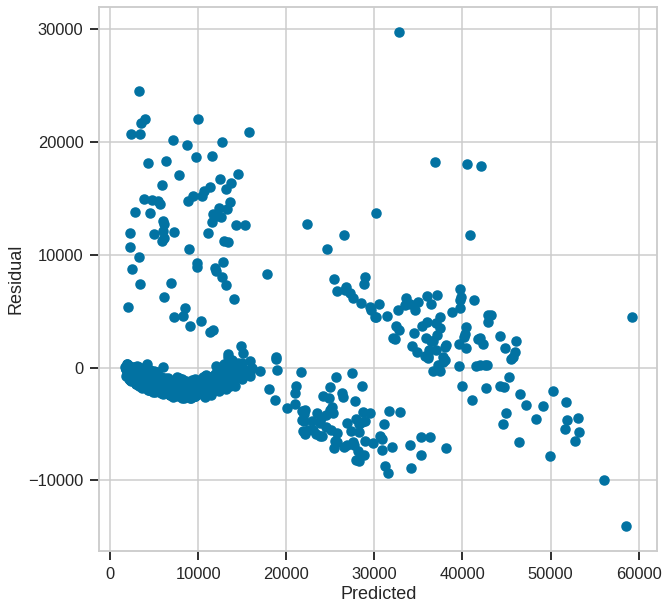

In [35]:
pred_val = fitted.fittedvalues.copy()
true_val = train.charges
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(pred_val, residual)
ax.set_ylabel('Residual')
ax.set_xlabel('Predicted')

## Influence
* We're interested in high influence & high leverage (outliers)
* Several points have high residuals, but not high influence
* Points 128 & 1047 could be a concerns
* If we see many outliers, we could switch over to robust regression

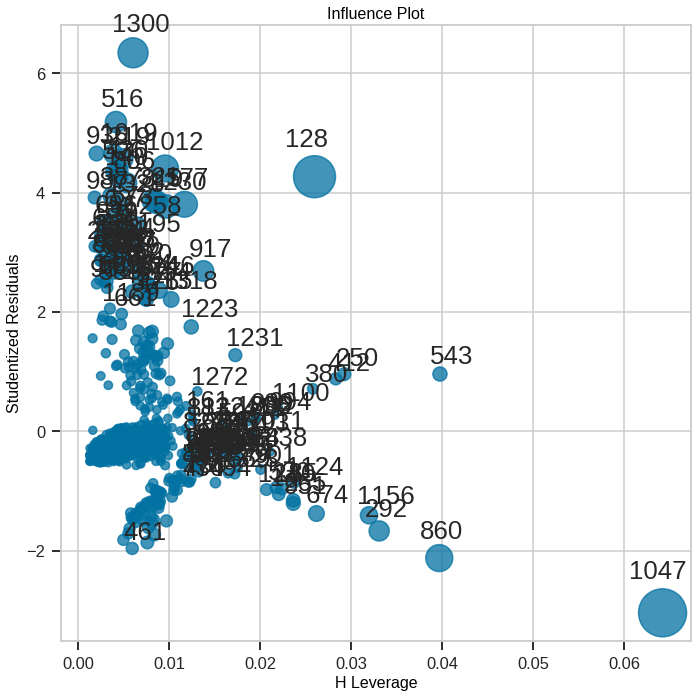

In [36]:
plt.rc("figure", figsize=(10,10))
fig = sm.graphics.influence_plot(fitted, criterion="cooks")
fig.tight_layout(pad=1)

## Holdout Error

In [37]:
compare_df = pd.DataFrame(columns=['MAE', 'RMSE'])

In [38]:
pred = fitted.predict(test)
mae  = mean_absolute_error(test.charges, pred)
mse  = mean_squared_error(test.charges, pred)
rmse = mse ** 0.5
print(f'MAE :  {mae:.2f}')
print(f'RMSE:  {rmse:.2f}')
compare_df.loc['Interaction'] = [mae, rmse]

MAE :  2983.89
RMSE:  5116.24


# Explanation

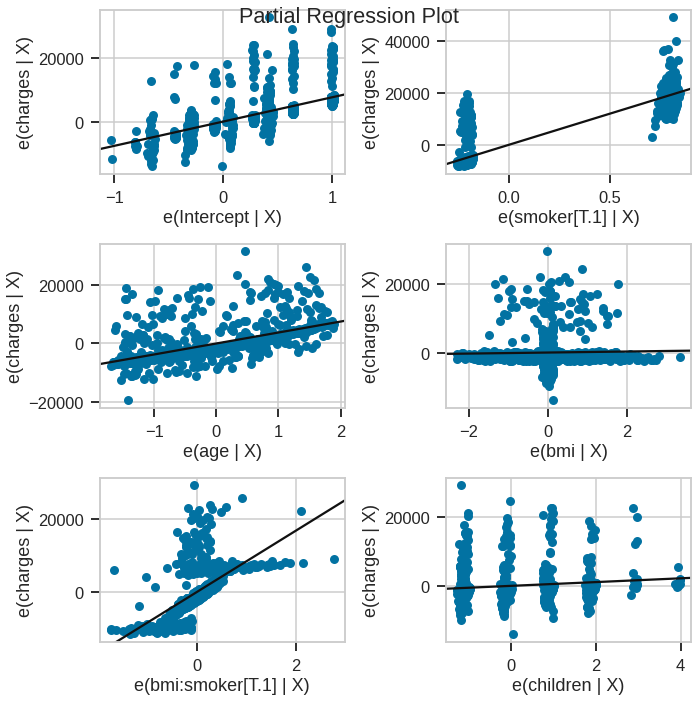

In [39]:
fig = sm.graphics.plot_partregress_grid(fitted)
fig.tight_layout(pad=1.0)

# Smoker vs Non-Smoker
* Can separate models outperform?
* We stargaze a model for smokers and nonsmokers
* Measure and compare MAE & RMSE

In [40]:
smoker_df = train[train.smoker == 1]
non_df    = train[train.smoker == 0]

## Smoker Model

In [41]:
cols = train.columns.to_list()
remove = ['charges',
          'sex', 
          'smoker',
          'children',
          'children_missing', 
          'sex_missing', 
          'smoker_missing', 
          'age_missing',
          'region_1', 
          'region_2', 
          'region_3', 
          'region_4']
for item in remove:
  cols.remove(item)

formula = 'charges ~ ' + ' + '.join(cols)

smoker_model = ols(formula=formula, data=smoker_df)
fitted_smoker = smoker_model.fit()
print(fitted_smoker.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     275.8
Date:                Thu, 04 Feb 2021   Prob (F-statistic):           1.32e-58
Time:                        15:00:58   Log-Likelihood:                -2084.2
No. Observations:                 206   AIC:                             4174.
Df Residuals:                     203   BIC:                             4184.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.231e+04    420.920     76.772      0.0

## Non-Smoker Model

In [42]:
cols = train.columns.to_list()
remove = ['charges',
          'bmi',
          'sex', 
          'smoker',
          'children_missing', 
          'sex_missing', 
          'smoker_missing', 
          'age_missing',
          'region_1',
          'region_2',
          'region_4']
for item in remove:
  cols.remove(item)

formula = 'charges ~ ' + ' + '.join(cols)

nonsmoker_model = ols(formula=formula, data=non_df)
fitted_nonsmoker = nonsmoker_model.fit()
print(fitted_nonsmoker.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     206.8
Date:                Thu, 04 Feb 2021   Prob (F-statistic):           4.48e-99
Time:                        15:00:59   Log-Likelihood:                -7813.0
No. Observations:                 797   AIC:                         1.563e+04
Df Residuals:                     793   BIC:                         1.565e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7805.6906    223.111     34.986      0.0

## Holdout Error 

In [43]:
test_smoker    = test[test.smoker == 1]
test_nonsmoker = test[test.smoker == 0]

In [44]:
pred_smoker    = fitted_smoker.predict(test_smoker)
pred_nonsmoker = fitted_nonsmoker.predict(test_nonsmoker)
pred    = pd.concat([pred_smoker, pred_nonsmoker])
charges = pd.concat([test_smoker.charges, test_nonsmoker.charges])
mae  = mean_absolute_error(charges, pred)
mse  = mean_squared_error(charges, pred)
rmse = mse ** 0.5
print(f'MAE :  {mae:.2f}')
print(f'RMSE:  {rmse:.2f}')
compare_df.loc['Separate'] = [mae, rmse]

MAE :  2980.38
RMSE:  5161.70


## Comparison
* Close, separate models barely improves MAE and is slightly worse on RMSE
* Not worth the complexity

In [45]:
compare_df

,MAE,RMSE
Interaction,2983.890284,5116.244694
Separate,2980.379888,5161.695220


# Machine Learning
* Reuse our data to run with Sklearn

In [46]:
compare_ml_df = pd.DataFrame(columns=['MAE', 'RMSE'])

In [47]:
train_y = train.charges
test_y  = test.charges

train_X = train.copy()
train_X = train_X.drop(columns=['charges'])

test_X  = test.copy()
test_X  = test_X.drop(columns=['charges'])

In [48]:
train_X

,age,sex,bmi,children,smoker,age_missing,children_missing,sex_missing,smoker_missing,region_1,region_2,region_3,region_4
302,1.195680,0,1.132372,2.0,0,0.0,0.0,0.0,0.0,0,1,0,0
561,1.053277,0,0.336281,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0
247,-1.082758,1,0.860415,0.0,0,0.0,0.0,0.0,0.0,0,1,0,0
25,1.409283,0,-0.481236,3.0,0,0.0,0.0,0.0,0.0,0,1,0,0
706,0.839674,0,1.223024,0.0,1,0.0,0.0,0.0,0.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.127662,0,-1.464399,1.0,0,0.0,0.0,0.0,0.0,0,0,0,0
1256,0.839674,0,0.946947,3.0,0,0.0,0.0,0.0,0.0,1,0,0,0
860,-0.157143,0,2.795426,2.0,1,0.0,0.0,0.0,0.0,0,0,1,0
189,-0.726752,0,0.242333,2.0,0,0.0,0.0,0.0,0.0,1,0,0,0


## Full Model

In [49]:
lm = LinearRegression()
lm.fit(train_X, train_y)

LinearRegression()

In [50]:
print(f'Intercept: {lm.intercept_:,.2f}')
for feature, coef in zip(train_X.columns, lm.coef_):
  print(f'{feature}: {coef:,.2f}')

Intercept: 8,365.60
age: 3,691.06
sex: 17.74
bmi: 2,178.89
children: 463.66
smoker: 24,164.94
age_missing: -0.00
children_missing: 3,502.89
sex_missing: 864.64
smoker_missing: -502.34
region_1: -73.32
region_2: -965.36
region_3: -1,508.21
region_4: -2,643.54


In [51]:
pred = lm.predict(test_X)
mae  = mean_absolute_error(test_y, pred)
mse  = mean_squared_error(test_y, pred)
rmse = mse ** 0.5
print(f'MAE: {mae:,.2f} RMSE: {rmse:,.2f}')
compare_ml_df.loc['Full Model'] = [mae, rmse]

MAE: 4,465.79 RMSE: 6,515.94


## Feature Selection
* Use L1 to induce sparsity
* Increase alpha from 1 to 100

In [52]:
lm1 = Lasso(alpha=100)
lm1.fit(train_X, train_y)

Lasso(alpha=100)

In [53]:
lm1.alpha

100

In [54]:
print(f'Intercept: {lm1.intercept_:,.2f}')
for feature, coef in zip(train_X.columns, lm1.coef_):
  print(f'{feature}: {coef:,.2f}')

Intercept: 8,033.10
age: 3,597.26
sex: 0.00
bmi: 1,973.43
children: 417.11
smoker: 23,589.44
age_missing: 0.00
children_missing: 0.00
sex_missing: 0.00
smoker_missing: -0.00
region_1: 0.00
region_2: -0.00
region_3: -476.05
region_4: -0.00


In [55]:
pred = lm1.predict(test_X)
mae  = mean_absolute_error(test_y, pred)
mse  = mean_squared_error(test_y, pred)
rmse = mse ** 0.5
print(f'MAE: {mae:,.2f} RMSE: {rmse:,.2f}')
compare_ml_df.loc['L1 Model'] = [mae, rmse]

MAE: 4,391.31 RMSE: 6,458.97


## Interaction Model
* You can directly add interactions to your dataframe
* Add polynomial features with sklearn Polynomial Features
* Construct a formula with Patsy

In [56]:
train_X['bmi:smoker'] = train_X.bmi * train_X.smoker.cat.codes
test_X ['bmi:smoker'] = test_X.bmi  * test_X.smoker.cat.codes

In [57]:
lm1 = Lasso(alpha=100)
lm1.fit(train_X, train_y)

Lasso(alpha=100)

In [58]:
print(f'Intercept: {lm1.intercept_:,.2f}')
for feature, coef in zip(train_X.columns, lm1.coef_):
  print(f'{feature}: {coef:,.2f}')

Intercept: 8,000.88
age: 3,651.30
sex: -0.00
bmi: 165.92
children: 482.28
smoker: 23,383.10
age_missing: 0.00
children_missing: 0.00
sex_missing: -0.00
smoker_missing: -0.00
region_1: 0.00
region_2: -0.00
region_3: -553.62
region_4: -0.00
bmi:smoker: 7,963.72


In [59]:
pred = lm1.predict(test_X)
mae  = mean_absolute_error(test_y, pred)
mse  = mean_squared_error(test_y, pred)
rmse = mse ** 0.5
print(f'MAE: {mae:,.2f} RMSE: {rmse:,.2f}')
compare_ml_df.loc['Interaction Model'] = [mae, rmse]

MAE: 3,053.76 RMSE: 5,141.73


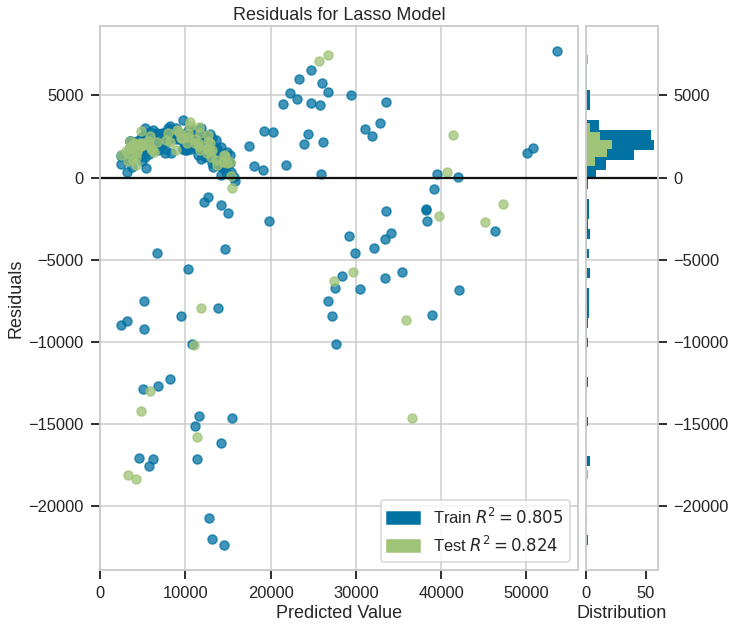

In [60]:
residuals_plot(lm1, test_X, test_y)

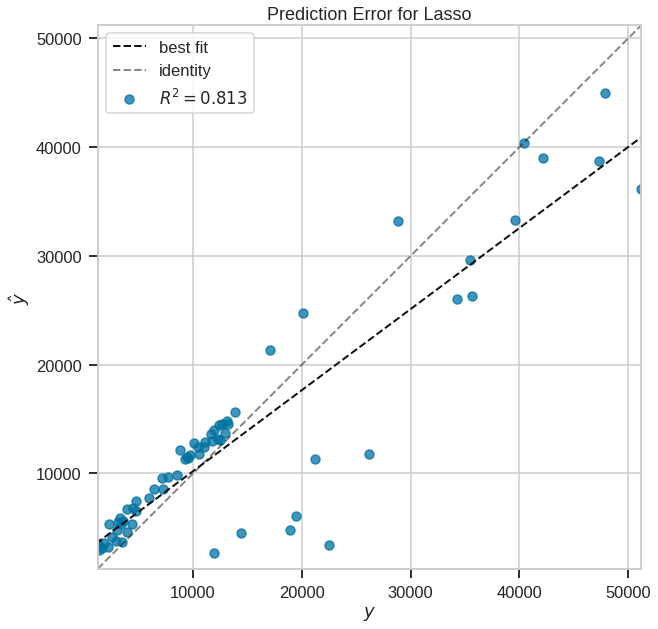

In [61]:
prediction_error(lm1, test_X, test_y)

## Tuning Alpha

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:213: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



AlphaSelection(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ddd553be0>,
               model=None)

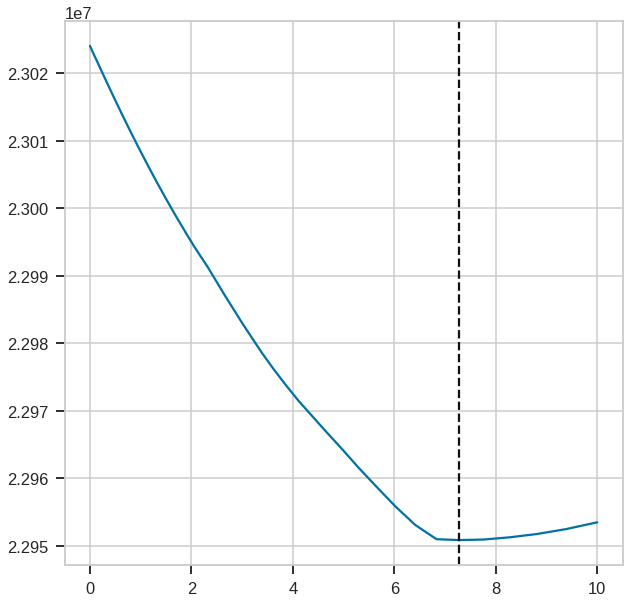

In [62]:
alphas = np.logspace(-10, 1, 400)
model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(train_X, train_y)

In [63]:
print(f'Intercept: {model.intercept_:,.2f}')
for feature, coef in zip(train_X.columns, model.coef_):
  print(f'{feature}: {coef:,.2f}')

Intercept: 8,541.09
age: 3,733.73
sex: -368.57
bmi: 263.06
children: 543.01
smoker: 23,985.07
age_missing: 0.00
children_missing: 535.78
sex_missing: -0.00
smoker_missing: -0.00
region_1: -277.95
region_2: -938.62
region_3: -1,519.36
region_4: -783.35
bmi:smoker: 8,398.97


In [64]:
pred = model.predict(test_X)
mae  = mean_absolute_error(test_y, pred)
mse  = mean_squared_error(test_y, pred)
rmse = mse ** 0.5
print(f'MAE: {mae:,.2f} RMSE: {rmse:,.2f}')
compare_ml_df.loc['Tuned Alpha'] = [mae, rmse]

MAE: 2,987.70 RMSE: 5,150.30


## Comparison

In [65]:
compare_ml_df

,MAE,RMSE
Full Model,4465.791823,6515.943800
L1 Model,4391.308102,6458.972363
Interaction Model,3053.756167,5141.725821
Tuned Alpha,2987.704673,5150.304406


In [66]:
compare_df

,MAE,RMSE
Interaction,2983.890284,5116.244694
Separate,2980.379888,5161.695220
